In [1]:
from deep_traffic_generation.tcvae_pairs import TCVAE_Pairs
from deep_traffic_generation.VAE_Generation import PairsVAE
from traffic.algorithms.generation import Generation
from deep_traffic_generation.core.datasets import TrafficDatasetPairsRandom
from traffic.core import Traffic

from sklearn.preprocessing import MinMaxScaler
import torch
import numpy as np
from os import walk

In [2]:
dataset = TrafficDatasetPairsRandom.from_file(
    ("../deep_traffic_generation/data/training_datasets/to_LSZH_16_100.pkl", "../deep_traffic_generation/data/training_datasets/ga_LSZH_14_100.pkl"),
    features=["track", "groundspeed", "altitude", "timedelta"],
    n_samples = 10000,
    scaler=MinMaxScaler(feature_range=(-1,1)),
    # scaler=None,
    shape="image",
    info_params={"features": ["latitude", "longitude"], "index": -1},
)

ATTENTION: 
A chaque fois qu'on génère un dataset, les paires sont prises aléatoirement parmi toutes les paires possibles (nb(ga)*nb(to) = 550000 possiblités). Lors de l'entrainement, on prend aléatoirement un sous ensemble des paires (7000 pour la V6). Lorsqu'on appelle la classe TrafficDatasetPairsRandom pour analyser les résultats, on ne peut pas regénérer exactement le dataset qui a été utiliser pour l'apprentissage. Cela signifie que, lorsqu'on analyse la "reconstruction", on analyse la reconstruction de paires qui n'ont pas forcément été vue durant l'apprentissage. En revanche, cela permet de voir si les encoders takeoffs et goarounds ont été efficaces pour apprendre à reconstruire leurs trajectoires respectives. 

Plusieurs possibilité :
- Soit on laisse comme ça et on spécifie bien qu'on a pas les paires de l'apprentissages, mais les trajectories individuelles ont quand même été vues dans d'autres paires dans l'apprentissages. C'est la'ssociations des trajesctoires qui n'est pas le même
- Soit on apprend sur toutes les possibilités. Ca fait beaucoup et on a beaucoup d'information redondant. On même go around est vu dans nb(to) paires différentes
- Soit On fait le choix des paires avant (une liste d'int), on sauvegarde, et on passe cette liste à la classe TrafficDatasetPairsRandom.

In [3]:
path = "../deep_traffic_generation/lightning_logs/tcvae_pairs/version_5/"

t = PairsVAE(X = dataset, vae_type="TCVAEPairs", sim_type = "generation")
t.load(path, dataset.parameters)
g = Generation(generation=t, features = t.VAE.hparams.features, scaler=dataset.scaler) 

In [4]:
traffic_to = Traffic.from_file("../deep_traffic_generation/data/training_datasets/to_LSZH_16_100.pkl")
latlon = traffic_to.data.groupby(by="flight_id")[["latitude", "longitude"]].first()
print("Take-offs:", latlon.latitude.mean(), latlon.longitude.mean())

traffic_ga = Traffic.from_file("../deep_traffic_generation/data/training_datasets/ga_LSZH_14_100.pkl")
latlon = traffic_ga.data.groupby(by="flight_id")[["latitude", "longitude"]].first()
print("Go-Arounds:", latlon.latitude.mean(), latlon.longitude.mean())

Take-offs: 47.44463545742907 8.557321498760901
Go-Arounds: 47.500085790354625 8.5114919243637


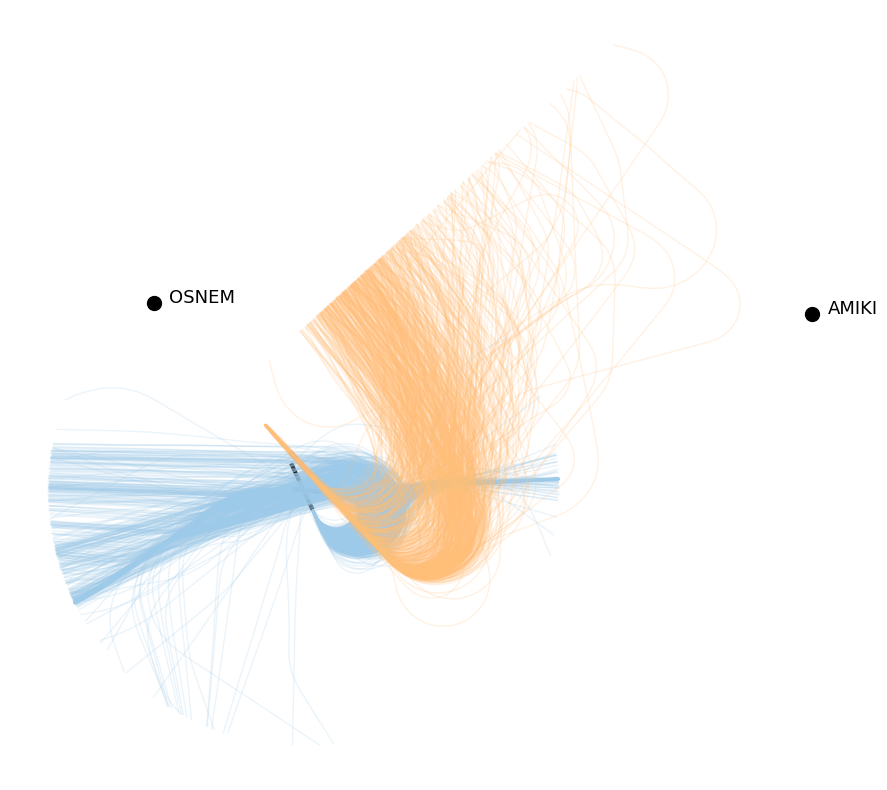

In [5]:
import matplotlib.pyplot as plt
from traffic.core.projection import EuroPP
from traffic.data import navaids, airports

with plt.style.context("traffic"):
    fig, ax = plt.subplots(figsize=(15, 10), subplot_kw=dict(projection=EuroPP()))

    traffic_to[:1000].plot(ax, alpha=0.2, color = "#9ecae9")
    traffic_ga.plot(ax, alpha = 0.2, color = "#ffbf79")

    airports["LSZH"].plot(ax, footprint=False, runways=dict(lw=1), labels=False)
    navaids["OSNEM"].plot(ax)
    navaids["AMIKI"].plot(ax)

plt.show()

# Latent space

In [4]:
import torch

with torch.no_grad():
    h1 = t.VAE.encoder_traj1(dataset.data1)
    h2 = t.VAE.encoder_traj2(dataset.data2)
    h = torch.cat((h1, h2), dim = 1)
    q = t.VAE.lsr(h)

    #Scale of the decoders networks
    print(t.VAE.scale_traj1, t.VAE.scale_traj2) 

Parameter containing:
tensor([0.0589], requires_grad=True) Parameter containing:
tensor([0.0368], requires_grad=True)


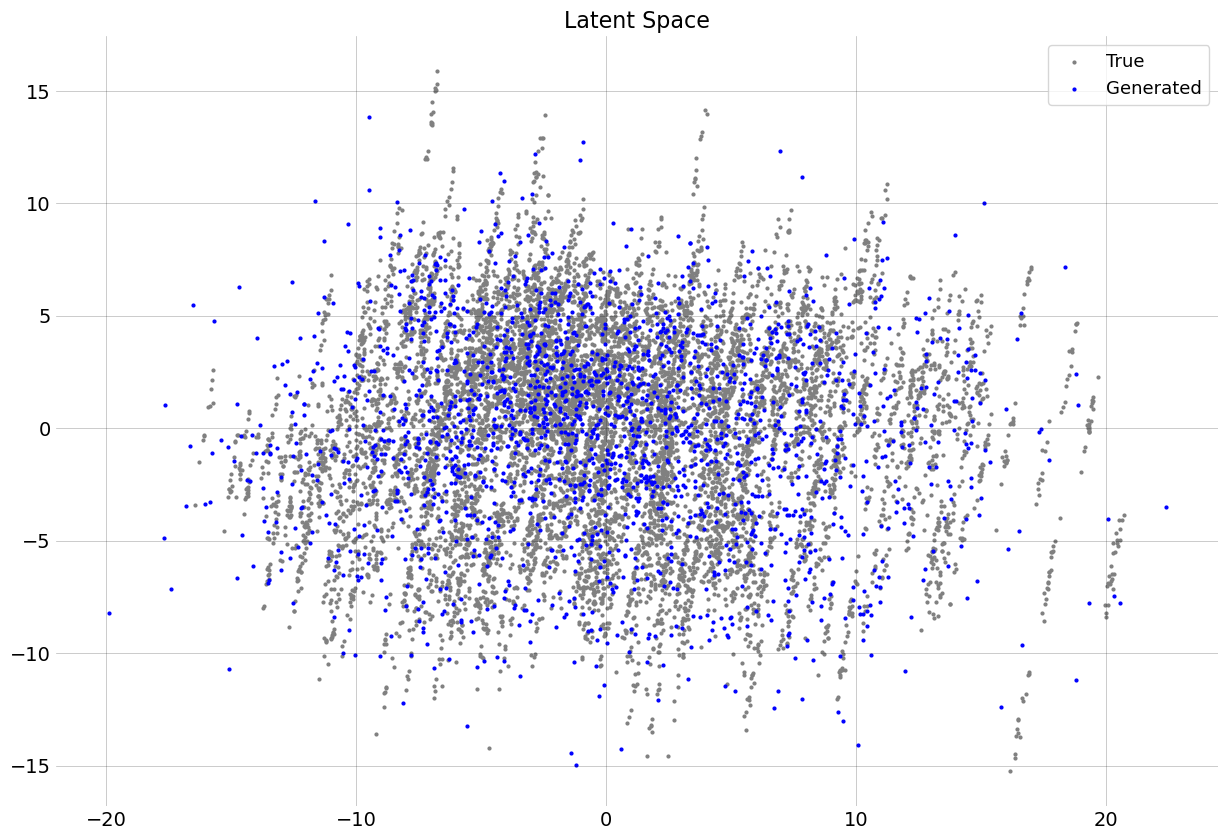

In [8]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

n_gen = 2000
Z, Z_gen = t.latent_space(n_gen)

#Only fitted on train data
pca = PCA(n_components=2).fit(Z)
Z_emb = pca.transform(Z)
Z_gen_emb = pca.transform(Z_gen)

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, figsize=(15, 10))
    ax.scatter(Z_emb[:, 0], Z_emb[:, 1], s=4, c ='grey', label = "True")
    ax.scatter(Z_gen_emb[:, 0], Z_gen_emb[:, 1], s=4, c='blue', label = "Generated")
    
    ax.title.set_text("Latent Space")
    ax.legend()

    plt.show()

### Testing of distirbutions of Total Correlation

In [9]:
from torch.distributions import Normal, Independent
from numbers import Number
import torch
import math

def logsumexp(value, dim=None, keepdim=False):
    """Numerically stable implementation of the operation
    value.exp().sum(dim, keepdim).log()
    """
    if dim is not None:
        m, _ = torch.max(value, dim=dim, keepdim=True)
        value0 = value - m
        if keepdim is False:
            m = m.squeeze(dim)
        return m + torch.log(torch.sum(torch.exp(value0),
                                    dim=dim, keepdim=keepdim))
    else:
        m = torch.max(value)
        sum_exp = torch.sum(torch.exp(value - m))
        if isinstance(sum_exp, Number):
            return m + math.log(sum_exp)
        else:
            return m + torch.log(sum_exp)

In [10]:
z = torch.Tensor(Z)

#Tests on the prior for the marginals
pz = t.VAE.lsr.get_prior() #Multivariate Standard Gaussian
logpz = pz.log_prob(z) #log p(z)
pz_marginals = Normal(torch.zeros(z.shape[1]), torch.ones(z.shape[1])) #Get maringals of a multivariate standard gaussian
logpz_marginals = pz_marginals.log_prob(z)
print("marginals prior: ", (logpz == logpz_marginals.sum(1)).all().item())

#Test on the postriors
dist_params = t.VAE.lsr.dist_params(q)
q_zx = t.VAE.lsr.get_posterior(dist_params)
logq_zx = q_zx.log_prob(z) # compute log q(z_i|x_i) for each i
logqz_extended = q_zx.log_prob(z.view(-1, 1, z.shape[1])) # compute log q(z_j|x_i) for each i and j
print("Diagonal of extended is equal to log q(z_i|x_i): ", (logq_zx == logqz_extended.diagonal(dim1=0, dim2=1)).all().item())

#Take only one posterior -> for x_i fixed:
q_zx1 = Independent(Normal(dist_params[0][0], dist_params[1][0]),1)
print("Testing q(z_0|x_0): ", (q_zx1.log_prob(z[0]) == logq_zx[0]).item())
#In logqz_extended, the first dimension is the index of latent variable, the second dimension is the index of the posterior
#first index is the index of z, second index is the index x
print("testing log_qz_extended: ", (logqz_extended[:,0] == q_zx1.log_prob(z)).all().item())
#We have indeed that the estimate of q(z) = sum_j q(z_i|x_j) = sum(qz_extended, dim=1)
logqz = logsumexp(logqz_extended, dim=1) - math.log(z.shape[0]*100)

#The problem lies in the calculation of the product of the marginals
marginals = Normal(dist_params[0], dist_params[1]).log_prob(z.view(-1, 1, z.shape[1])) # size (n_batch, n_batch, latent_dim)
# As the posteriors are factorised, we should be able to retrive the log probs with the marginals
print("testing retrieving posteriors log probs with marginals: ", (logqz_extended == marginals.sum(2)).all().item())
logqz_bis = logsumexp(marginals.sum(2), dim=1) - math.log(z.shape[0]*100)
print("est1 == est2: ", (logqz == logqz_bis).all().item())
# Product of marginals is correct too
logqz_prodmarginals = (logsumexp(marginals, dim = 1) - math.log(z.shape[0] * z.shape[0])).sum(1)

# Calculation of different terms:
print("")
print("mi: ", (logq_zx - logqz).mean().item())
print("tc: ", (logqz - logqz_prodmarginals).mean().item())
print("kld_ew: ", (logqz_prodmarginals - logpz).mean().item())

print("")
print("kld_loss: ", (logq_zx - logpz).mean().item())

# On a bien mi + tc + kld_ew ~= kld_loss: C'est un bon estimateur !!

marginals prior:  False
Diagonal of extended is equal to log q(z_i|x_i):  True
Testing q(z_0|x_0):  True
testing log_qz_extended:  True
testing retrieving posteriors log probs with marginals:  True
est1 == est2:  True

mi:  13.814720153808594
tc:  115.87503814697266
kld_ew:  -92.13176727294922

kld_loss:  37.55799102783203


### Testing for prior marginals

In [11]:
from torch.distributions import Normal, Independent, MixtureSameFamily
from torch.distributions.categorical import Categorical

z = torch.Tensor(Z)

#Computing the pseudo inputs
pseudo_X = t.VAE.lsr.pseudo_inputs_NN(t.VAE.lsr.idle_input) 
pseudo_X1 = pseudo_X[:,:400].view((pseudo_X.shape[0], 4, 100))
pseudo_X2 = pseudo_X[:,400:].view((pseudo_X.shape[0], 4, 100))

pseudo_h1 = t.VAE.encoder_traj1(pseudo_X1)
pseudo_h2 = t.VAE.encoder_traj2(pseudo_X2)
pseudo_h = torch.cat((pseudo_h1, pseudo_h2), dim = 1)

pseudo_means = t.VAE.lsr.z_loc(pseudo_h)
pseudo_scales = (t.VAE.lsr.z_log_var(pseudo_h) / 2).exp()

#The marginals of a gaussian mixture are equal to the mixture of the marginals

#Tests on the prior for the marginals
pz = t.VAE.lsr.get_prior() #Multivariate gaussian mixture
logpz = pz.log_prob(z) #log p(z)

#Getting the marginals by constructing a batch of 10 gaussian mixtures in 1D with 700 components
cat_probs = Categorical(probs = pz.mixture_distribution.probs.repeat(10,1))
mu = pz.component_distribution.base_dist.loc.T.unsqueeze(2)
sigma = pz.component_distribution.base_dist.scale.T.unsqueeze(2)
marginals_comp = Independent(Normal(mu, sigma), 1)
marginals = MixtureSameFamily(cat_probs, marginals_comp)
test1 = marginals.log_prob(z.unsqueeze(2))

In [12]:
# To get the log of the factorzed distribution : 
dist = Independent(marginals, 1)
dist.log_prob(z.unsqueeze(2)) == test1.sum(1)


tensor([True, True, True,  ..., True, True, True])

In [15]:
len(dist.event_shape)

2

In [16]:
len(marginals.event_shape)

1

In [83]:
# log prob of each z for each marginals of the prior
# let p(z) = prod_j sum_i (w_i * f_i(z_j)) where i is the component and j the marginal
# for z fixed, prior_marginals_ij = log(f_i(z_j))
# the sum over j gives the logprob of each component
# to get the marginals: logsumexp weighted by w_i over i
# log_marginals is (for one z and one column j): log sum_i (w_i * f_i(z_j))
prior_marginals = Normal(pz.component_distribution.base_dist.loc, pz.component_distribution.base_dist.scale).log_prob(z.view(-1, 1, z.shape[1]))
weights = pz.mixture_distribution.probs.repeat(10000,10,1).transpose(2,1)
log_marginals = torch.sum(weights * torch.exp(prior_marginals), dim = 1).log()

#We actually have test1 = log_marginals



# Reconstruction

In [10]:
from traffic.core.projection import EuroPP
from traffic.data import airports
from traffic.drawing import countries
import matplotlib.pyplot as plt

j = np.random.randint(len(dataset))

#Original trajectories
original1 = dataset.data1[j].unsqueeze(0)
original1 = original1.transpose(1,2).reshape((original1.shape[0], -1))
original2 = dataset.data2[j].unsqueeze(0)
original2 = original2.transpose(1,2).reshape((original2.shape[0], -1))
original = torch.cat((original1, original2), dim = 1)
original = dataset.scaler.inverse_transform(original)
original_traf_to = g.build_traffic(original[:,:original1.shape[1]], coordinates = dict(latitude =  47.44464, longitude = 8.55732), forward=True)
original_traf_ga = g.build_traffic(original[:,original2.shape[1]:], coordinates = dict(latitude = 47.500086, longitude = 8.51149), forward=True)

#Latest variables
h1 = t.VAE.encoder_traj1(dataset.data1[j].unsqueeze(0))
h2 = t.VAE.encoder_traj2(dataset.data2[j].unsqueeze(0))
h = torch.cat((h1, h2), dim = 1)
z = t.VAE.lsr(h).rsample()

#Reconstruction
decoded = t.decode(z)
reconstructed_traf_to = g.build_traffic(decoded[:,:400], coordinates = dict(latitude =  47.44464, longitude = 8.55732), forward=True)
reconstructed_traf_ga = g.build_traffic(decoded[:,400:], coordinates = dict(latitude = 47.500086, longitude = 8.51149), forward=True)


with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, subplot_kw=dict(projection=EuroPP()))
    original_traf_to.plot(ax, c="#4c78a8", lw = 3, label = "Original")
    original_traf_ga.plot(ax, c="#4c78a8", lw = 3)
    reconstructed_traf_to.plot(ax, c="orange", label = "Reconstructed")
    reconstructed_traf_ga.plot(ax, c="orange")
    plt.legend()

    airports["LSZH"].plot(ax, footprint=False, runways=dict(lw=1), labels=False)

    plt.show()

: 

: 

# Generation

## Pseudo-inputs

In [7]:
#Computing the pseudo inputs
pseudo_X = t.VAE.lsr.pseudo_inputs_NN(t.VAE.lsr.idle_input) 
pseudo_X1 = pseudo_X[:,:400].view((pseudo_X.shape[0], 4, 100))
pseudo_X2 = pseudo_X[:,400:].view((pseudo_X.shape[0], 4, 100))

pseudo_h1 = t.VAE.encoder_traj1(pseudo_X1)
pseudo_h2 = t.VAE.encoder_traj2(pseudo_X2)
pseudo_h = torch.cat((pseudo_h1, pseudo_h2), dim = 1)

pseudo_means = t.VAE.lsr.z_loc(pseudo_h)
pseudo_scales = (t.VAE.lsr.z_log_var(pseudo_h) / 2).exp()

AttributeError: 'NormalLSR' object has no attribute 'pseudo_inputs_NN'

In [43]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from traffic.core.projection import EuroPP
from traffic.data import airports
from traffic.drawing import countries

decoded = t.decode(pseudo_means)
t1, t2 = decoded[:,:400], decoded[:,400:]
t1[:,3] = 0
t2[:,3] = 0
gen_traf_to = g.build_traffic(t1, coordinates = dict(latitude =  47.44464, longitude = 8.55732), forward=True)
gen_traf_ga = g.build_traffic(t2, coordinates = dict(latitude = 47.500086, longitude = 8.51149), forward=True)

z_train = t.latent_space(0)
pca = PCA(n_components=2).fit(z_train)
Z = np.concatenate((z_train, pseudo_means.detach().numpy()), axis=0)
Z_embedded = pca.transform(Z)

/tmp/ipykernel_22665/4255555629.py:40: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(points, ax=ax0)


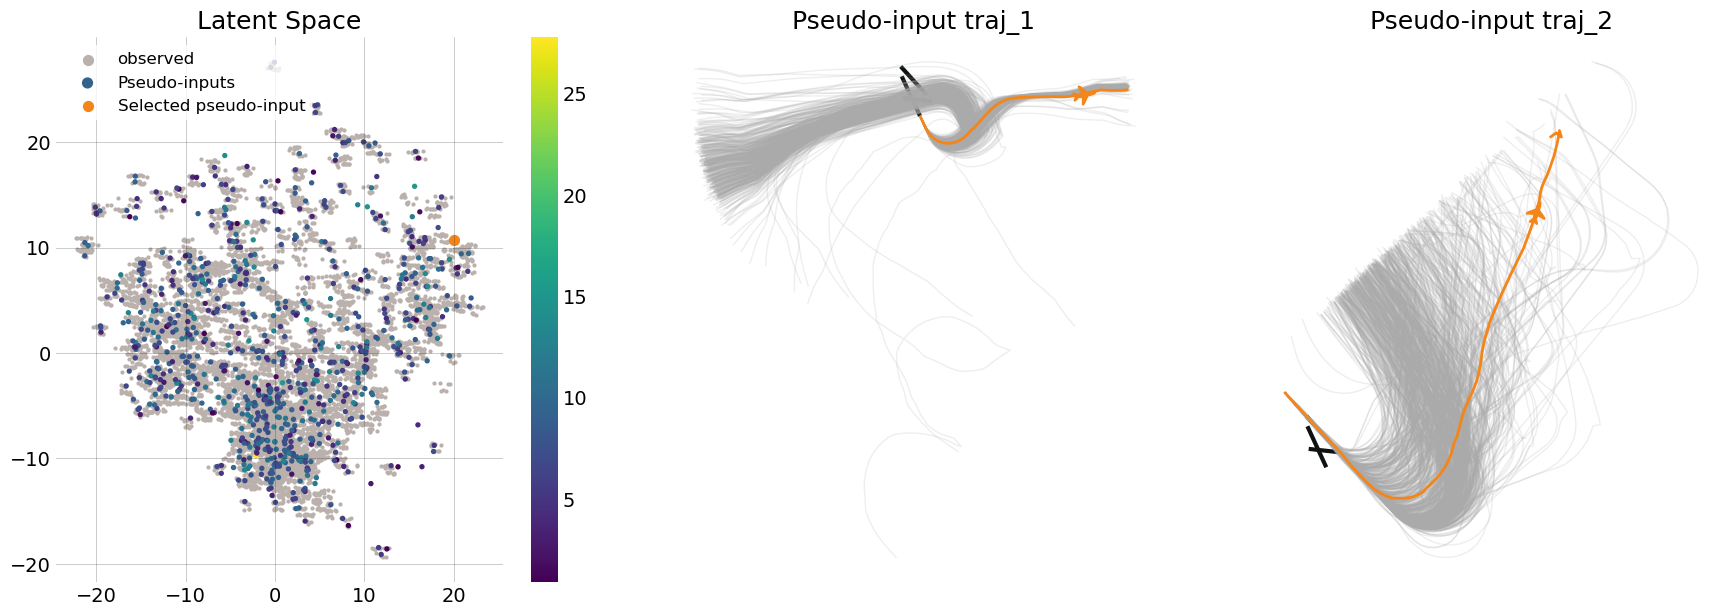

In [44]:
#col depending on the scales
col = torch.norm(pseudo_scales, dim = 1, p = 2).detach().numpy()

with plt.style.context("traffic"):
    fig = plt.figure(figsize=(18, 12))
    ax0 = fig.add_subplot(231)
    ax1 = fig.add_subplot(232, projection=EuroPP())
    ax2 = fig.add_subplot(233, projection=EuroPP())

    k = np.random.randint(800)


    ax0.scatter(
        Z_embedded[:-len(pseudo_means), 0], Z_embedded[:-len(pseudo_means), 1], c="#bab0ac", s=4, label="observed"
    )
    points = ax0.scatter(
        Z_embedded[-len(pseudo_means):, 0],
        Z_embedded[-len(pseudo_means):, 1],
        s=8,
        c=col,
        cmap="viridis",
        label="Pseudo-inputs",
    )
    ax0.scatter(
        Z_embedded[z_train.shape[0]+k, 0],
        Z_embedded[z_train.shape[0]+k, 1],
        s=50,
        marker="o",
        c="#f58518",
        label="Selected pseudo-input",
    )
    ax0.set_title("Latent Space", fontsize=18)

    legend = ax0.legend(loc="upper left", fontsize=12)
    legend.get_frame().set_edgecolor("none")
    legend.legendHandles[0]._sizes = [50]
    legend.legendHandles[1]._sizes = [50]
    legend.legendHandles[2]._sizes = [50]

    fig.colorbar(points, ax=ax0)

    ax1.set_title("Pseudo-input traj_1", fontsize=18)
    gen_traf_to.plot(ax1, alpha=0.2)
    gen_traf_to["TRAJ_" + str(k)].plot(ax1, color="#f58518", lw=2)
    gen_traf_to["TRAJ_" + str(k)].at_ratio(0.85).plot(
        ax1,
        color="#f58518",
        zorder=5,
        text_kw={"s": None},
    )
    
    ax2.set_title("Pseudo-input traj_2", fontsize=18)
    gen_traf_ga.plot(ax2, alpha=0.2)
    gen_traf_ga["TRAJ_" + str(k)].plot(ax2, color="#f58518", lw=2)
    gen_traf_ga["TRAJ_" + str(k)].at_ratio(0.85).plot(
        ax2,
        color="#f58518",
        zorder=5,
        text_kw={"s": None},
    )

    airports["LSZH"].plot(ax1, footprint=False, runways=dict(lw=1), labels=False)
    airports["LSZH"].plot(ax2, footprint=False, runways=dict(lw=1), labels=False)
    fig.tight_layout()
    plt.show()

# Random Generation

In [45]:
import pandas as pd

j = np.random.randint(0,800)
# j = 529
n_gen = 100

dist = torch.distributions.Independent(
    torch.distributions.Normal(pseudo_means[j], pseudo_scales[j]), 1
)
gen = dist.sample(torch.Size([n_gen]))

decoded = t.decode(
    torch.cat((pseudo_means[j].unsqueeze(0), gen), axis=0)
)
decode1, decode2 = decoded[:,:400], decoded[:,400:]
decode1[:, 3] = 0
decode2[:, 3] = 0

traf_gen1 = g.build_traffic(decode1, coordinates =  dict(latitude =  47.44464, longitude = 8.55732), forward=True)
traf_gen1 = traf_gen1.assign(gen_number=lambda x: 1)

traf_gen2 = g.build_traffic(decode2, coordinates = dict(latitude = 47.500086, longitude = 8.51149), forward=True)
traf_gen2 = traf_gen2.assign(gen_number=lambda x: 2)

z_train = t.latent_space(0)
pca = PCA(n_components=2).fit(z_train)
gen = torch.cat((gen, pseudo_means[j].unsqueeze(0)), axis=0)
concat = np.concatenate((z_train, gen.detach().numpy()))
gen_embedded = pca.transform(concat)

gen_embedded = pd.DataFrame(gen_embedded, columns=["X1", "X2"])
gen_embedded["type"] = np.nan
gen_embedded.type[-(n_gen + 1) :] = "GEN"
gen_embedded.type[-1:] = "PI"

/tmp/ipykernel_22665/362819912.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gen_embedded.type[-(n_gen + 1) :] = "GEN"


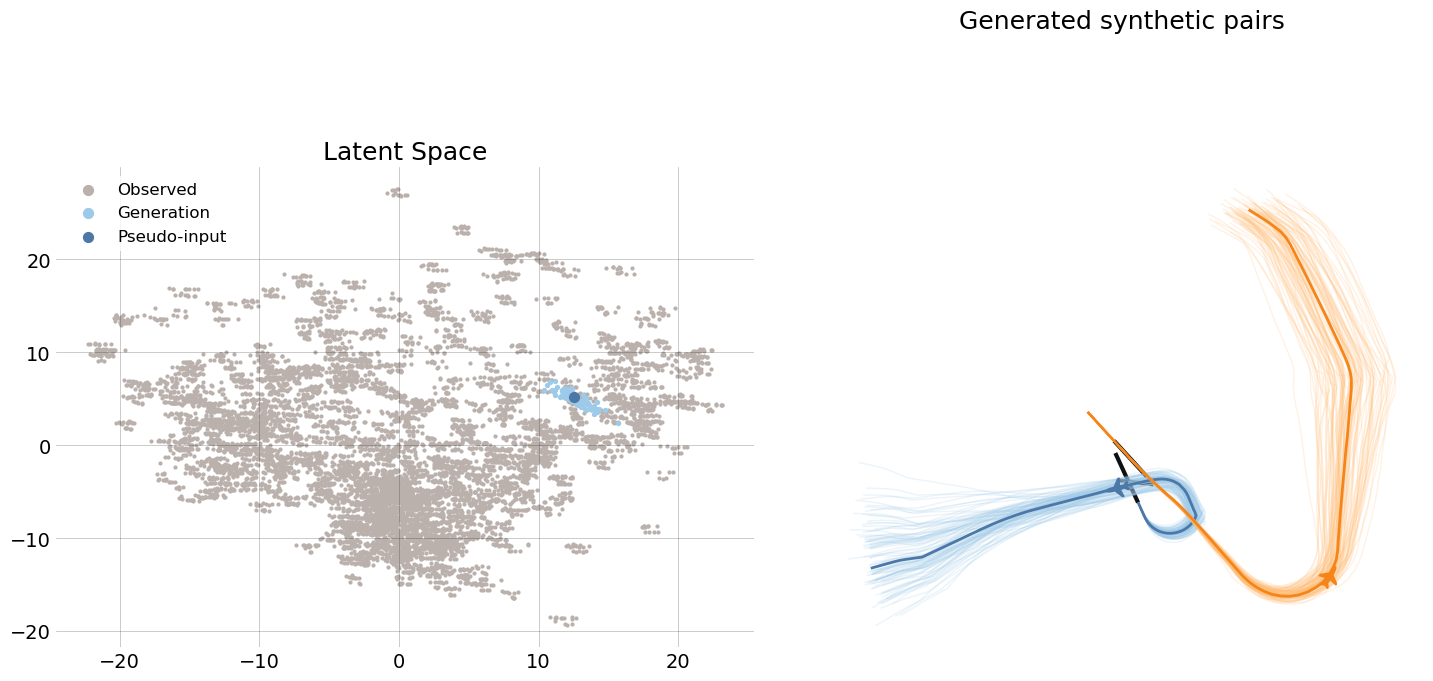

In [46]:
with plt.style.context("traffic"):
    fig = plt.figure(figsize=(15, 12))
    ax0 = fig.add_subplot(221)
    ax1 = fig.add_subplot(222, projection=EuroPP())

    ax0.scatter(
        gen_embedded.query("type.isnull()").X1,
        gen_embedded.query("type.isnull()").X2,
        c="#bab0ac",
        s=4,
        label="Observed",
    )
    ax0.scatter(
        gen_embedded.query("type == 'GEN'").X1,
        gen_embedded.query("type == 'GEN'").X2,
        c="#9ecae9",
        s=8,
        label="Generation",
    )
    ax0.scatter(
        gen_embedded.query("type == 'PI'").X1,
        gen_embedded.query("type == 'PI'").X2,
        c="#4c78a8",
        s=50,
        label="Pseudo-input",
    )
    ax0.set_title("Latent Space", fontsize=18)

    legend = ax0.legend(loc="upper left", fontsize=12)
    legend.get_frame().set_edgecolor("none")
    legend.legendHandles[0]._sizes = [50]
    legend.legendHandles[1]._sizes = [50]
    legend.legendHandles[2]._sizes = [50]

    ax1.set_title("Generated synthetic pairs", pad=100, fontsize=18)

    traf_gen1.plot(ax1, alpha=0.2, color="#9ecae9")
    traf_gen1["TRAJ_0"].plot(ax1, color="#4c78a8", lw=2)
    traf_gen1["TRAJ_0"].at_ratio(0.5).plot(
        ax1,
        color="#4c78a8",
        zorder=5,
        text_kw={"s": None},
    )

    traf_gen2.plot(ax1, alpha=0.2, color="#ffbf79")
    traf_gen2["TRAJ_0"].plot(ax1, color="#f58518", lw=2)
    traf_gen2["TRAJ_0"].at_ratio(0.5).plot(
        ax1,
        color="#f58518",
        zorder=5,
        text_kw={"s": None},
    )

    airports["LSZH"].plot(ax1, footprint=False, runways=dict(lw=1), labels=False)
    fig.tight_layout()

    plt.show()

Notes for the time shift between go-arounds et take-offs:
- On est obligé de le modéliser séparéement parce qu'on ne peut pas directement apprendre le delta_t entre to et ga car c'est jamais observé dnas la vraie vie. 
- On ne peut pas faire comme les take-offs et les landings d'ORLY
- Idée: prendre des delta_t dans une uniforme, et regarder le range de delta_t qui sont le plus dangereux

# Thoughts about disentanglement

- Il faut à priori avoir une prior factorisée du style une N(0,1). A priori on ne peut plus utiliser VampPrior parce que les dimensions ne sont pas intépendantes. Est-ce que ça va marcher ? Peut-on réussir à faire une mixture gaussienne dont on est sûr que les dimensions soient indépendantes ?
- Il faut partir du beta VAE et réécrire la Loss. Le beta est un hyperparamètre qui doit être tuné à la main. On va devoir écrire une nouvelle classe pairsVAE_disentangled dans le script abstract.py. 
- Peut-être au'il faudra réécrire une nouvelle LSR dans lsr.py. Mais à priori normalLSR devrait faire l'affaire. 
- La question de l'évaluation du disentanglement va se poser. Il faut d'abord se concentrer sur la visualisation. Il faut d'abord classer les dimensions les plus importantes (voir papier beta VAE ou diagnosing and enhancing VAE). Puis faire une visualisation avec un slider qui prend en entrée un point de l'espace latent + une dimension. Avec le slider, on peut modifier la valeur sur cette dimension particulière tout en gardant les autres fixes, et on peut visualiser les modifications qui sont faites sur la paire de trajectoires. (a la limite, faire une video au lieu d'un plot interactif)


Heatmaps:
 - Plotly hexvolumes heatmap
 - from folium.plugins import HeatMap